# COMPAS Recidivism example

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from cohortshapley import similarity
from cohortshapley import cohortshapley as cs

## Load data

The data is obtained from https://github.com/propublica/compas-analysis (See Angwin et al. 2016)

In [2]:
import os
import urllib

def compas_recidivism():
    data_dir = 'dataset'
    file_dir = 'dataset/compas'
    file_path = 'dataset/compas/compas-scores-two-years.csv'
    url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
    if not os.path.isdir(file_dir):
        os.mkdir(file_dir)
    if not os.path.isfile(file_path):
        urllib.request.urlretrieve(url, file_path)
    df = pd.read_csv(file_path,index_col=False,
                     skipinitialspace=True, na_values='?')
    # preprocess follows Angwin et al. 2016.
    df = df[df['days_b_screening_arrest']<=30]
    df = df[df['days_b_screening_arrest']>=-30]
    df = df[df['is_recid'] != -1]
    df = df[df['c_charge_degree'] != 'O']
    df = df[df['score_text'] != 'N/A']
    def age(val):
        res = 0
        if val<25:
            res = 1
        elif val<=45:
            res = 2
        else:
            res = 3
        return res
    def race(val):
        res = 0
        if val == 'Caucasian':
            res = 1
        elif val == 'African-American':
            res = 2
        elif val == 'Hispanic':
            res = 3
        elif val == 'Asian':
            res = 4
        elif val == 'Native American':
            res = 5
        else:
            res = 6
        return res
    # The definition of categories for prior_count is from Chouldecova 2017.
    def prior(val):
        if val == 0:
            res = 0
        elif val <= 3:
            res = 1
        elif val <= 6:
            res = 2
        elif val <= 10:
            res = 3
        else:
            res = 4
        return res
    df['priors_count'] = df['priors_count'].apply(prior)
    df['crime_factor'] = df['c_charge_degree'].apply(lambda x: 1 if x == 'M' else 2)
    df['age_factor'] = df['age'].apply(age)
    df['race_factor'] = df['race'].apply(race)
    df['gender_factor'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 2)
    df['score_factor'] = df['decile_score'].apply(lambda x: 1 if x >= 5 else 0)
    #  select data subjects of White and Black
    df = df[df['race_factor'] <= 2]
    X = df[['priors_count','crime_factor','age_factor','race_factor','gender_factor']]
    Y = df[['score_factor','two_year_recid','decile_score']]
    return X, Y, df

In [3]:
X, Y, df = compas_recidivism()

## Splitting and Differencing by Protected Variable

In [4]:
Y['TP'] = ((Y['score_factor'] == 1).values & (Y['two_year_recid'] == 1).values).astype(int)
Y['FP'] = ((Y['score_factor'] == 1).values & (Y['two_year_recid'] == 0).values).astype(int)
Y['TN'] = ((Y['score_factor'] == 0).values & (Y['two_year_recid'] == 0).values).astype(int)
Y['FN'] = ((Y['score_factor'] == 0).values & (Y['two_year_recid'] == 1).values).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [5]:
X_wr = X.copy()
X_wor = X.drop('race_factor', axis=1)

In [6]:
Y['res'] = Y['two_year_recid'] - Y['score_factor']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Statistical group fairness metrices

Here, we assume 'Caucasian' as privilleged group and others as unprivilleged group.

In [7]:
is_priv = X['race_factor'] == 1
is_unpriv = ~is_priv
n_priv = is_priv.sum()
n_unpriv = is_unpriv.sum()
print('Number of subjects in  privileged group: ', n_priv, ' unpriviledged group: ', n_unpriv)

Number of subjects in  privileged group:  2103  unpriviledged group:  3175


### Demographic parity

In [8]:
priv_r = Y['two_year_recid'][is_priv]
unpriv_r = Y['two_year_recid'][is_unpriv]
priv_r_ratio = (priv_r == 1).sum() / n_priv
unpriv_r_ratio = (unpriv_r == 1).sum() / n_unpriv
print('Priviledged group: ', priv_r_ratio, ' unpriviledged group: ', unpriv_r_ratio)
print('Total: ', Y['two_year_recid'].mean())
print('Demographic parity: ', unpriv_r_ratio - priv_r_ratio )

Priviledged group:  0.3908701854493581  unpriviledged group:  0.5231496062992126
Total:  0.47044334975369456
Demographic parity:  0.1322794208498545


In [9]:
priv_fc = Y['score_factor'][is_priv]
unpriv_fc = Y['score_factor'][is_unpriv]
priv_fc_ratio = (priv_fc == 1).sum() / n_priv
unpriv_fc_ratio = (unpriv_fc == 1).sum() / n_unpriv
print('Priviledged group: ', priv_fc_ratio, ' unpriviledged group: ', unpriv_fc_ratio)
print('Total: ', Y['score_factor'].mean())
print('Demographic parity: ', unpriv_fc_ratio - priv_fc_ratio )

Priviledged group:  0.3309557774607703  unpriviledged group:  0.5760629921259842
Total:  0.4784009094353922
Demographic parity:  0.2451072146652139


### Equal opportunity

= FPR = FP / (FP + TN)

In [10]:
priv_fpr = Y['FP'][is_priv].sum() / (Y['FP'][is_priv].sum() + Y['TN'][is_priv].sum())
unpriv_fpr = Y['FP'][is_unpriv].sum() / (Y['FP'][is_unpriv].sum() + Y['TN'][is_unpriv].sum())
print('Priviledged group: ', priv_fpr, ' unpriviledged group: ', unpriv_fpr)
print('Equal opportunity: ', unpriv_fpr - priv_fpr )
print('Total: ', Y['FP'].sum() / (Y['FP'].sum() + Y['TN'].sum()))

Priviledged group:  0.22014051522248243  unpriviledged group:  0.4233817701453104
Equal opportunity:  0.203241254922828
Total:  0.3302325581395349


### FNR
= FN / (FN + TP)

In [11]:
priv_fnr = Y['FN'][is_priv].sum() / (Y['FN'][is_priv].sum() + Y['TP'][is_priv].sum())
unpriv_fnr = Y['FN'][is_unpriv].sum() / (Y['FN'][is_unpriv].sum() + Y['TP'][is_unpriv].sum())
print('Priviledged group: ', priv_fpr, ' unpriviledged group: ', unpriv_fpr)
print('Equal opportunity: ', unpriv_fpr - priv_fpr )
print('Total: ', Y['FN'].sum() / (Y['FN'].sum() + Y['TP'].sum()))

Priviledged group:  0.22014051522248243  unpriviledged group:  0.4233817701453104
Equal opportunity:  0.203241254922828
Total:  0.35481272654047524


### TPR
= TP / (TP + FN)

In [12]:
priv_tpr = Y['TP'][is_priv].sum() / (Y['TP'][is_priv].sum() + Y['FN'][is_priv].sum())
unpriv_tpr = Y['TP'][is_unpriv].sum() / (Y['TP'][is_unpriv].sum() + Y['FN'][is_unpriv].sum())
print('Priviledged group: ', priv_tpr, ' unpriviledged group: ', unpriv_tpr)
print('Equalized odd: ', unpriv_tpr - priv_tpr )

Priviledged group:  0.5036496350364964  unpriviledged group:  0.7152317880794702
Equalized odd:  0.2115821530429738


### Equalized odds difference
= TPR - FPR = TP / (TP + FN) - FP / (FP + TN)

In [13]:
print('Priviledged group: ', priv_tpr - priv_fpr, ' unpriviledged group: ', unpriv_tpr - unpriv_fpr)
print('Equalized odd: ', unpriv_tpr - unpriv_fpr - (priv_tpr - priv_fpr) )

Priviledged group:  0.28350911981401394  unpriviledged group:  0.29185001793415977
Equalized odd:  0.008340898120145823


### False discovery rate

In [14]:
priv_fdr = Y['FP'][is_priv].sum() / (Y['FP'][is_priv].sum() + Y['TP'][is_priv].sum())
unpriv_fdr = Y['FP'][is_unpriv].sum() / (Y['FP'][is_unpriv].sum() + Y['TP'][is_unpriv].sum())
print('Priviledged group: ', priv_fdr, ' unpriviledged group: ', unpriv_fdr)
print('FN ratio disparity: ', unpriv_fdr - priv_fdr )

Priviledged group:  0.4051724137931034  unpriviledged group:  0.35046473482777474
FN ratio disparity:  -0.05470767896532869


### PPV (Precision)
= TP / (TP+FP)

In [15]:
priv_ppv = Y['TP'][is_priv].sum() / (Y['TP'][is_priv].sum() + Y['FP'][is_priv].sum())
unpriv_ppv = Y['TP'][is_unpriv].sum() / (Y['TP'][is_unpriv].sum() + Y['FP'][is_unpriv].sum())
print('Priviledged group: ', priv_ppv, ' unpriviledged group: ', unpriv_ppv)
print('Equalized odd: ', unpriv_ppv - priv_ppv )

Priviledged group:  0.5948275862068966  unpriviledged group:  0.6495352651722253
Equalized odd:  0.05470767896532869


### FPV

In [16]:
priv_npv = Y['TN'][is_priv].sum() / (Y['TN'][is_priv].sum() + Y['FN'][is_priv].sum())
unpriv_npv = Y['TN'][is_unpriv].sum() / (Y['TN'][is_unpriv].sum() + Y['FN'][is_unpriv].sum())
print('Priviledged group: ', priv_npv, ' unpriviledged group: ', unpriv_npv)
print('Equalized odd: ', unpriv_npv - priv_npv )

Priviledged group:  0.7100213219616205  unpriviledged group:  0.6485884101040119
Equalized odd:  -0.061432911857608574


### Accuracy

In [17]:
priv_acc = (Y['TP'][is_priv].sum() + Y['TN'][is_priv].sum()) / n_priv
unpriv_acc = (Y['TP'][is_unpriv].sum() + Y['TN'][is_unpriv].sum()) / n_unpriv
print('Priviledged group: ', priv_acc, ' unpriviledged group: ', unpriv_acc)
print('Equalized odd: ', unpriv_acc - priv_acc )

Priviledged group:  0.6718972895863052  unpriviledged group:  0.6491338582677165
Equalized odd:  -0.02276343131858871


## Cohort Shapley Values

### Ground truth

In [18]:
subject = X_wr.values
similarity.ratio = 0.1
f=False
cs_truth = cs.CohortShapley(f, similarity.similar_in_samebin, np.arange(len(subject)), subject, y=Y['two_year_recid'].values, parallel=4)

use given y values instead of model prediction.


In [19]:
cs_truth.compute_cohort_shapley()

parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.


  0%|          | 0/1320 [00:00<?, ?it/s]

use given y values instead of model prediction.


100%|██████████| 1319/1319 [00:16<00:00, 81.17it/s]


### Binary prediction score

In [20]:
subject = X_wr.values
similarity.ratio = 0.1
f=False
cs_fc = cs.CohortShapley(f, similarity.similar_in_samebin, np.arange(len(subject)), subject, y=Y['score_factor'].values, parallel=4)

use given y values instead of model prediction.


In [21]:
cs_fc.compute_cohort_shapley()

parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.


100%|██████████| 1319/1319 [00:16<00:00, 81.45it/s]


### False Positive

In [22]:
subject = X_wr.values
similarity.ratio = 0.1
cs.dump=False
f=False
cs_fp = cs.CohortShapley(f, similarity.similar_in_samebin, np.arange(len(subject)), subject, y=Y['FP'].values, parallel=4)

use given y values instead of model prediction.


In [23]:
cs_fp.compute_cohort_shapley()

parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.


100%|██████████| 1320/1320 [00:18<00:00, 71.34it/s]


### False Negative

In [24]:
subject = X_wr.values
similarity.ratio = 0.1
cs.dump=False
f=False
cs_fn = cs.CohortShapley(f, similarity.similar_in_samebin, np.arange(len(subject)), subject, y=Y['FN'].values, parallel=4)

use given y values instead of model prediction.


In [25]:
cs_fn.compute_cohort_shapley()

parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.


100%|██████████| 1319/1319 [00:20<00:00, 64.73it/s]


### Residual

In [26]:
subject = X_wr.values
similarity.ratio = 0.1
cs.dump=False
f=False
cs_res = cs.CohortShapley(f, similarity.similar_in_samebin, np.arange(len(subject)), subject, y=Y['res'].values, parallel=4)

use given y values instead of model prediction.


In [27]:
cs_res.compute_cohort_shapley()

parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.


  0%|          | 0/1320 [00:00<?, ?it/s]

use given y values instead of model prediction.
use given y values instead of model prediction.


100%|██████████| 1320/1320 [00:23<00:00, 57.08it/s]


## for Histogram

In [28]:
# input vars are all categorical
bin_X_wr = similarity.binning(X_wr.values)
bin_idx = bin_X_wr[0]
bin_val = bin_X_wr[1]

In [29]:
def conditioned_shapley_hist(X, bin_val, shapley_values, condvar, expvar, bin_label=None, ylim=(0,2000), xlim=None):
    vals = bin_val[condvar]
    col = X.columns
    n_vals = len(vals)
    cond = {}
    for k in range(n_vals):
        cond[k] = np.where(X[col[condvar]] == vals[k])[0]
    jj = expvar
    for k in range(n_vals):
        v = shapley_values[:,jj]
        n_bins = 20
        bins = np.linspace(v.min(),v.max()+0.001, n_bins+1, endpoint=True)
        if bin_label:
            l = bin_label[k]
        else:
            l = k
        plt.hist(shapley_values[cond[k]][:,jj], bins=bins, alpha=0.5,label=l)
    plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)

In [30]:
def all_conditioned_shapley_hist(X, bin_val, shapley_values, ylim=(0,2000)):
    n_var = len(bin_val)
    for j in range(n_var):
        vals = bin_val[j]
        col = X.columns
        n_vals = len(vals)
        cond = {}
        for k in range(n_vals):
            cond[k] = np.where(X[col[j]] == vals[k])[0]
            y_max = 0
            for jj in range(n_var):
                y_max = 0
        for jj in range(n_var):
            plt.subplot(n_var,n_var,jj+n_var*j+1)
            for k in range(n_vals):
                v = shapley_values[:,jj]
                n_bins = 20
                bins = np.linspace(v.min(),v.max()+0.001, n_bins+1, endpoint=True)
                plt.hist(shapley_values[cond[k]][:,jj], bins=bins, alpha=0.5)
                if jj == 0:
                    plt.ylabel(col[j])
                if j == 0:
                    plt.title(col[jj])
                plt.ylim(ylim)
    plt.tight_layout()
    fig.text(0.5, 1.0, 'Impact of predictor variable', ha='center', va='center')
    fig.text(0.0, 0.5, 'Predictor variable conditioned on', ha='center', va='center', rotation='vertical')

In [31]:
def group_fairness_bar(priv_rate, unpriv_rate, total_rate, labels, xlim=None):
    plt.barh([0,1],[priv_rate, 0],  tick_label=None, alpha=0.5, height=0.5)
    plt.barh([0,1],[0, unpriv_rate], tick_label=None,alpha=0.5, height=0.5)
    ymin=-0.5
    ymax=1.5
    plt.vlines(total_rate, ymin, ymax, 'red', linestyles='dashed')
    plt.ylim(ymin,ymax)
    if xlim:
        plt.xlim(xlim)
    #plt.legend(bbox_to_anchor=(1,0), loc='lower left')
    plt.yticks([0,1],labels)

## Conventional Group Fairness Metrics

In [32]:
fc = Y['score_factor']
fc_ratio = Y['score_factor'].sum() / len(Y)
truth = Y['score_factor']
truth_ratio = Y['score_factor'].sum() / len(Y)
fpr_total = Y['FP'].sum() / (Y['FP'].sum() + Y['TN'].sum())
fnr_total = Y['FN'].sum() / (Y['FN'].sum() + Y['TP'].sum())
priv_res = Y['res'][is_priv]
unpriv_res = Y['res'][is_unpriv]
priv_res_ratio = priv_res.sum() / n_priv
unpriv_res_ratio = unpriv_res.sum() / n_unpriv
res_total = Y['res'].sum() / len(Y)

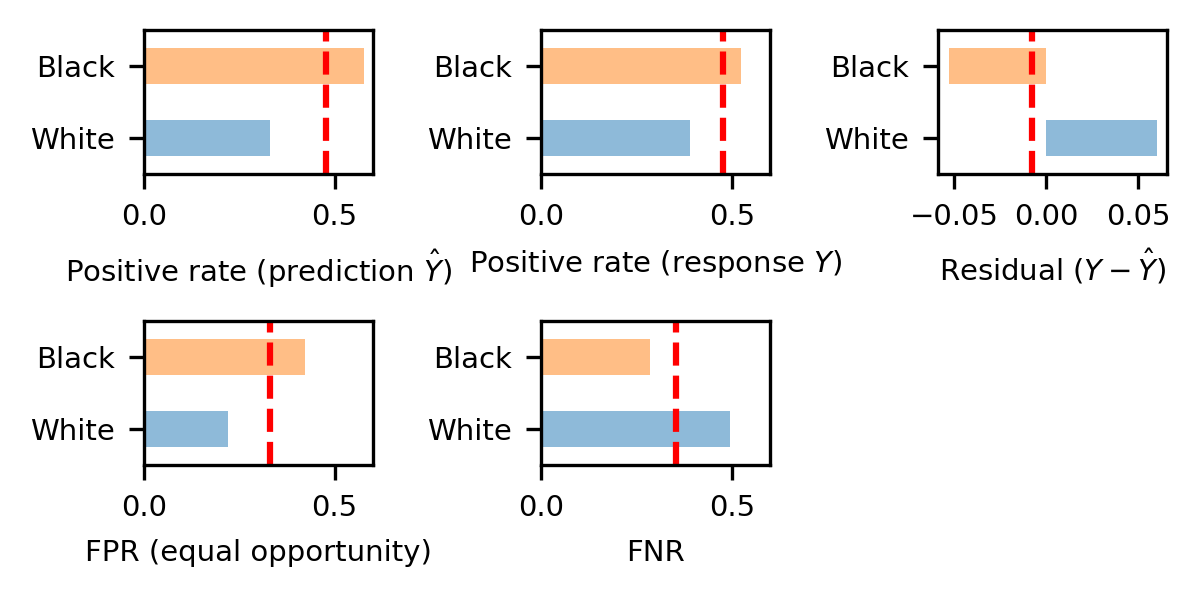

In [33]:
fig = plt.figure(figsize=(4,2),dpi=300)
plt.rcParams["font.size"] = 7
xlim=(0,0.6)
#
plt.subplot(2,3,1)
fc = Y['score_factor']
fc_ratio = Y['score_factor'].sum() / len(Y)
group_fairness_bar(priv_fc_ratio, unpriv_fc_ratio, fc_ratio, ['White','Black'], xlim)
plt.xlabel('Positive rate (prediction $\hat Y$)')
#
plt.subplot(2,3,2)
truth = Y['score_factor']
truth_ratio = Y['score_factor'].sum() / len(Y)
group_fairness_bar(priv_r_ratio, unpriv_r_ratio, truth_ratio, ['White','Black'],xlim)
plt.xlabel('Positive rate (response $Y$)')
#
plt.subplot(2,3,4)
fpr_total = Y['FP'].sum() / (Y['FP'].sum() + Y['TN'].sum())
group_fairness_bar(priv_fpr, unpriv_fpr, fpr_total, ['White','Black'],xlim)
plt.xlabel('FPR (equal opportunity)')
#
plt.subplot(2,3,5)
fnr_total = Y['FN'].sum() / (Y['FN'].sum() + Y['TP'].sum())
group_fairness_bar(priv_fnr, unpriv_fnr, fnr_total, ['White','Black'],xlim)
plt.xlabel('FNR')
#
plt.subplot(2,3,3)
res_total = Y['res'].sum() / len(Y)
group_fairness_bar(priv_res_ratio, unpriv_res_ratio, res_total, ['White','Black'])
plt.xlabel('Residual ($Y - \hat Y$)')
#
plt.tight_layout()
plt.show()

### Cohort Shapley Histogram

Text(0, 0.5, 'Frequency')

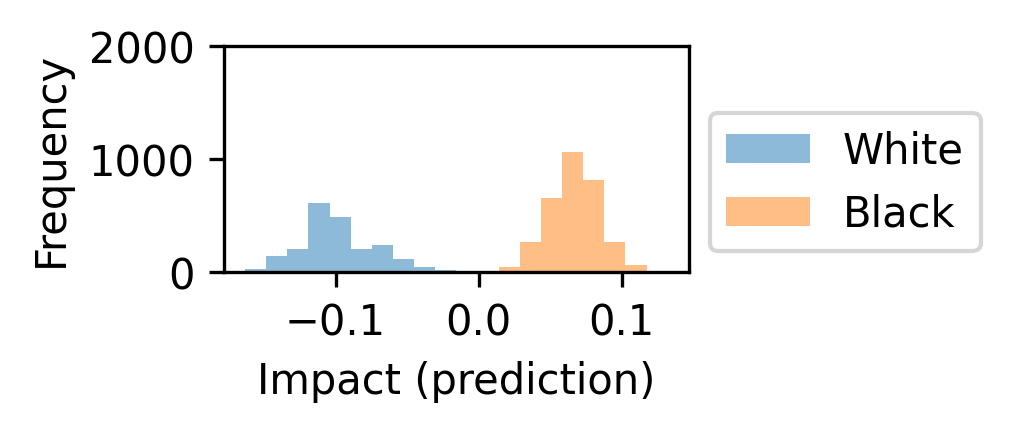

In [34]:
fig = plt.figure(figsize=(2,1),dpi=300)
plt.rcParams["font.size"] = 10
conditioned_shapley_hist(X_wr, bin_val, cs_fc.shapley_values,3,3, bin_label=['White','Black'])
plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (prediction)')
plt.ylabel('Frequency')

### race factor impact distribution for each race

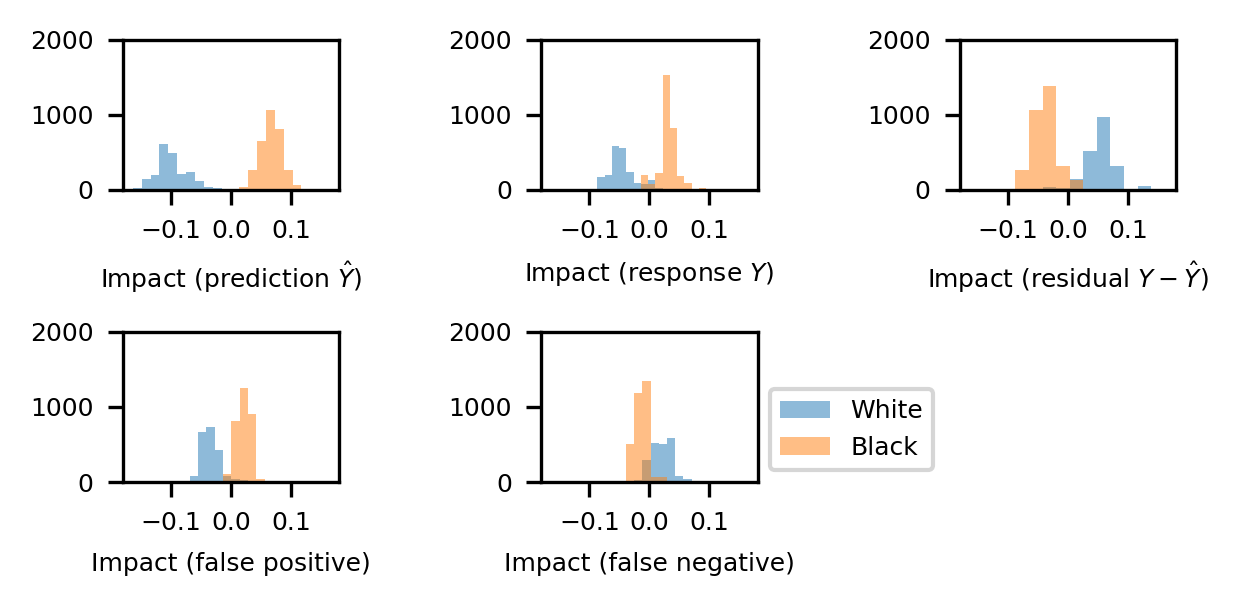

In [35]:
fig = plt.figure(figsize=(4,2),dpi=300)
plt.rcParams["font.size"] = 6

xlim=(-0.18, 0.18)
#
plt.subplot(2,3,1)
conditioned_shapley_hist(X_wr, bin_val, cs_fc.shapley_values,3,3, bin_label=['White','Black'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (prediction $\hat Y$)')
#
plt.subplot(2,3,2)
conditioned_shapley_hist(X_wr, bin_val, cs_truth.shapley_values,3,3, bin_label=['White','Black'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (response $Y$)')
#
plt.subplot(2,3,4)
conditioned_shapley_hist(X_wr, bin_val, cs_fp.shapley_values,3,3, bin_label=['White','Black'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (false positive)')
#
plt.subplot(2,3,5)
conditioned_shapley_hist(X_wr, bin_val, cs_fn.shapley_values,3,3, bin_label=['White','Black'],xlim=xlim)
plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (false negative)')
#
plt.subplot(2,3,3)
conditioned_shapley_hist(X_wr, bin_val, cs_res.shapley_values,3,3, bin_label=['White','Black'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (residual $Y - \hatY$)')
#
plt.tight_layout()
plt.show()

### race factor impact distribution for each gender

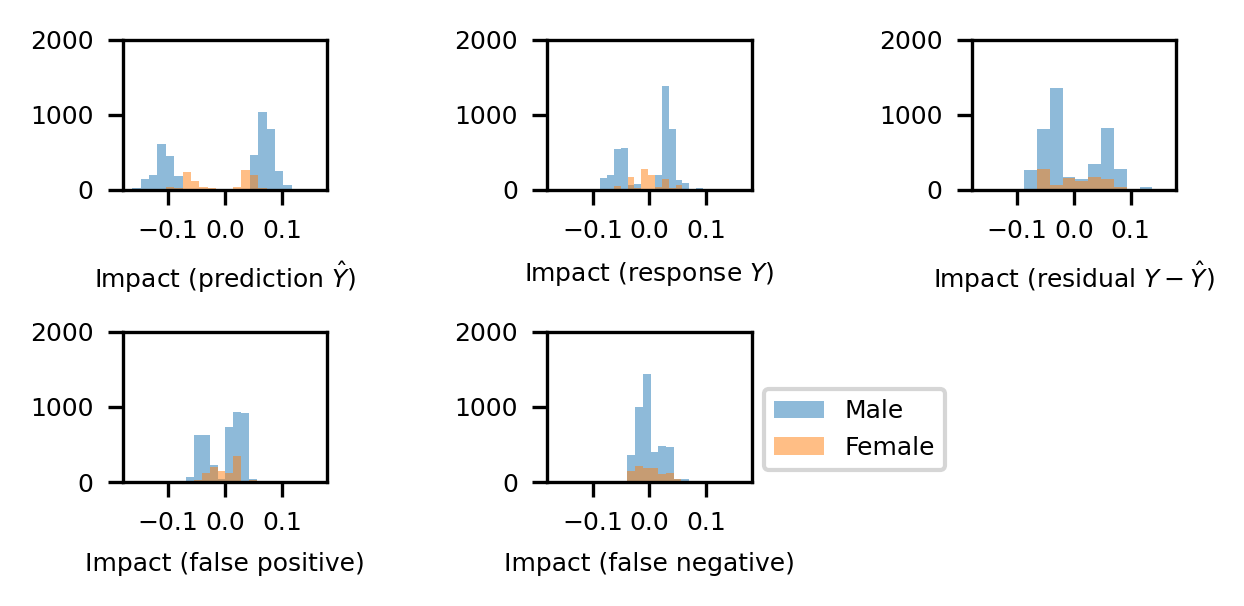

In [36]:
fig = plt.figure(figsize=(4,2),dpi=300)
plt.rcParams["font.size"] = 6
xlim=(-0.18, 0.18)
#
plt.subplot(2,3,1)
conditioned_shapley_hist(X_wr, bin_val, cs_fc.shapley_values,4,3, bin_label=['Male','Female'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (prediction $\hat Y$)')
#
plt.subplot(2,3,2)
conditioned_shapley_hist(X_wr, bin_val, cs_truth.shapley_values,4,3, bin_label=['Male','Female'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (response $Y$)')
#
plt.subplot(2,3,4)
conditioned_shapley_hist(X_wr, bin_val, cs_fp.shapley_values,4,3, bin_label=['Male','Female'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (false positive)')
#
plt.subplot(2,3,5)
conditioned_shapley_hist(X_wr, bin_val, cs_fn.shapley_values,4,3, bin_label=['Male','Female'],xlim=xlim)
plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (false negative)')
#
plt.subplot(2,3,3)
conditioned_shapley_hist(X_wr, bin_val, cs_res.shapley_values,4,3, bin_label=['Male','Female'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (residual $Y-\hat Y$)')
#
plt.tight_layout()
plt.show()

## All Histograms

### Prediction (Demographic Parity)

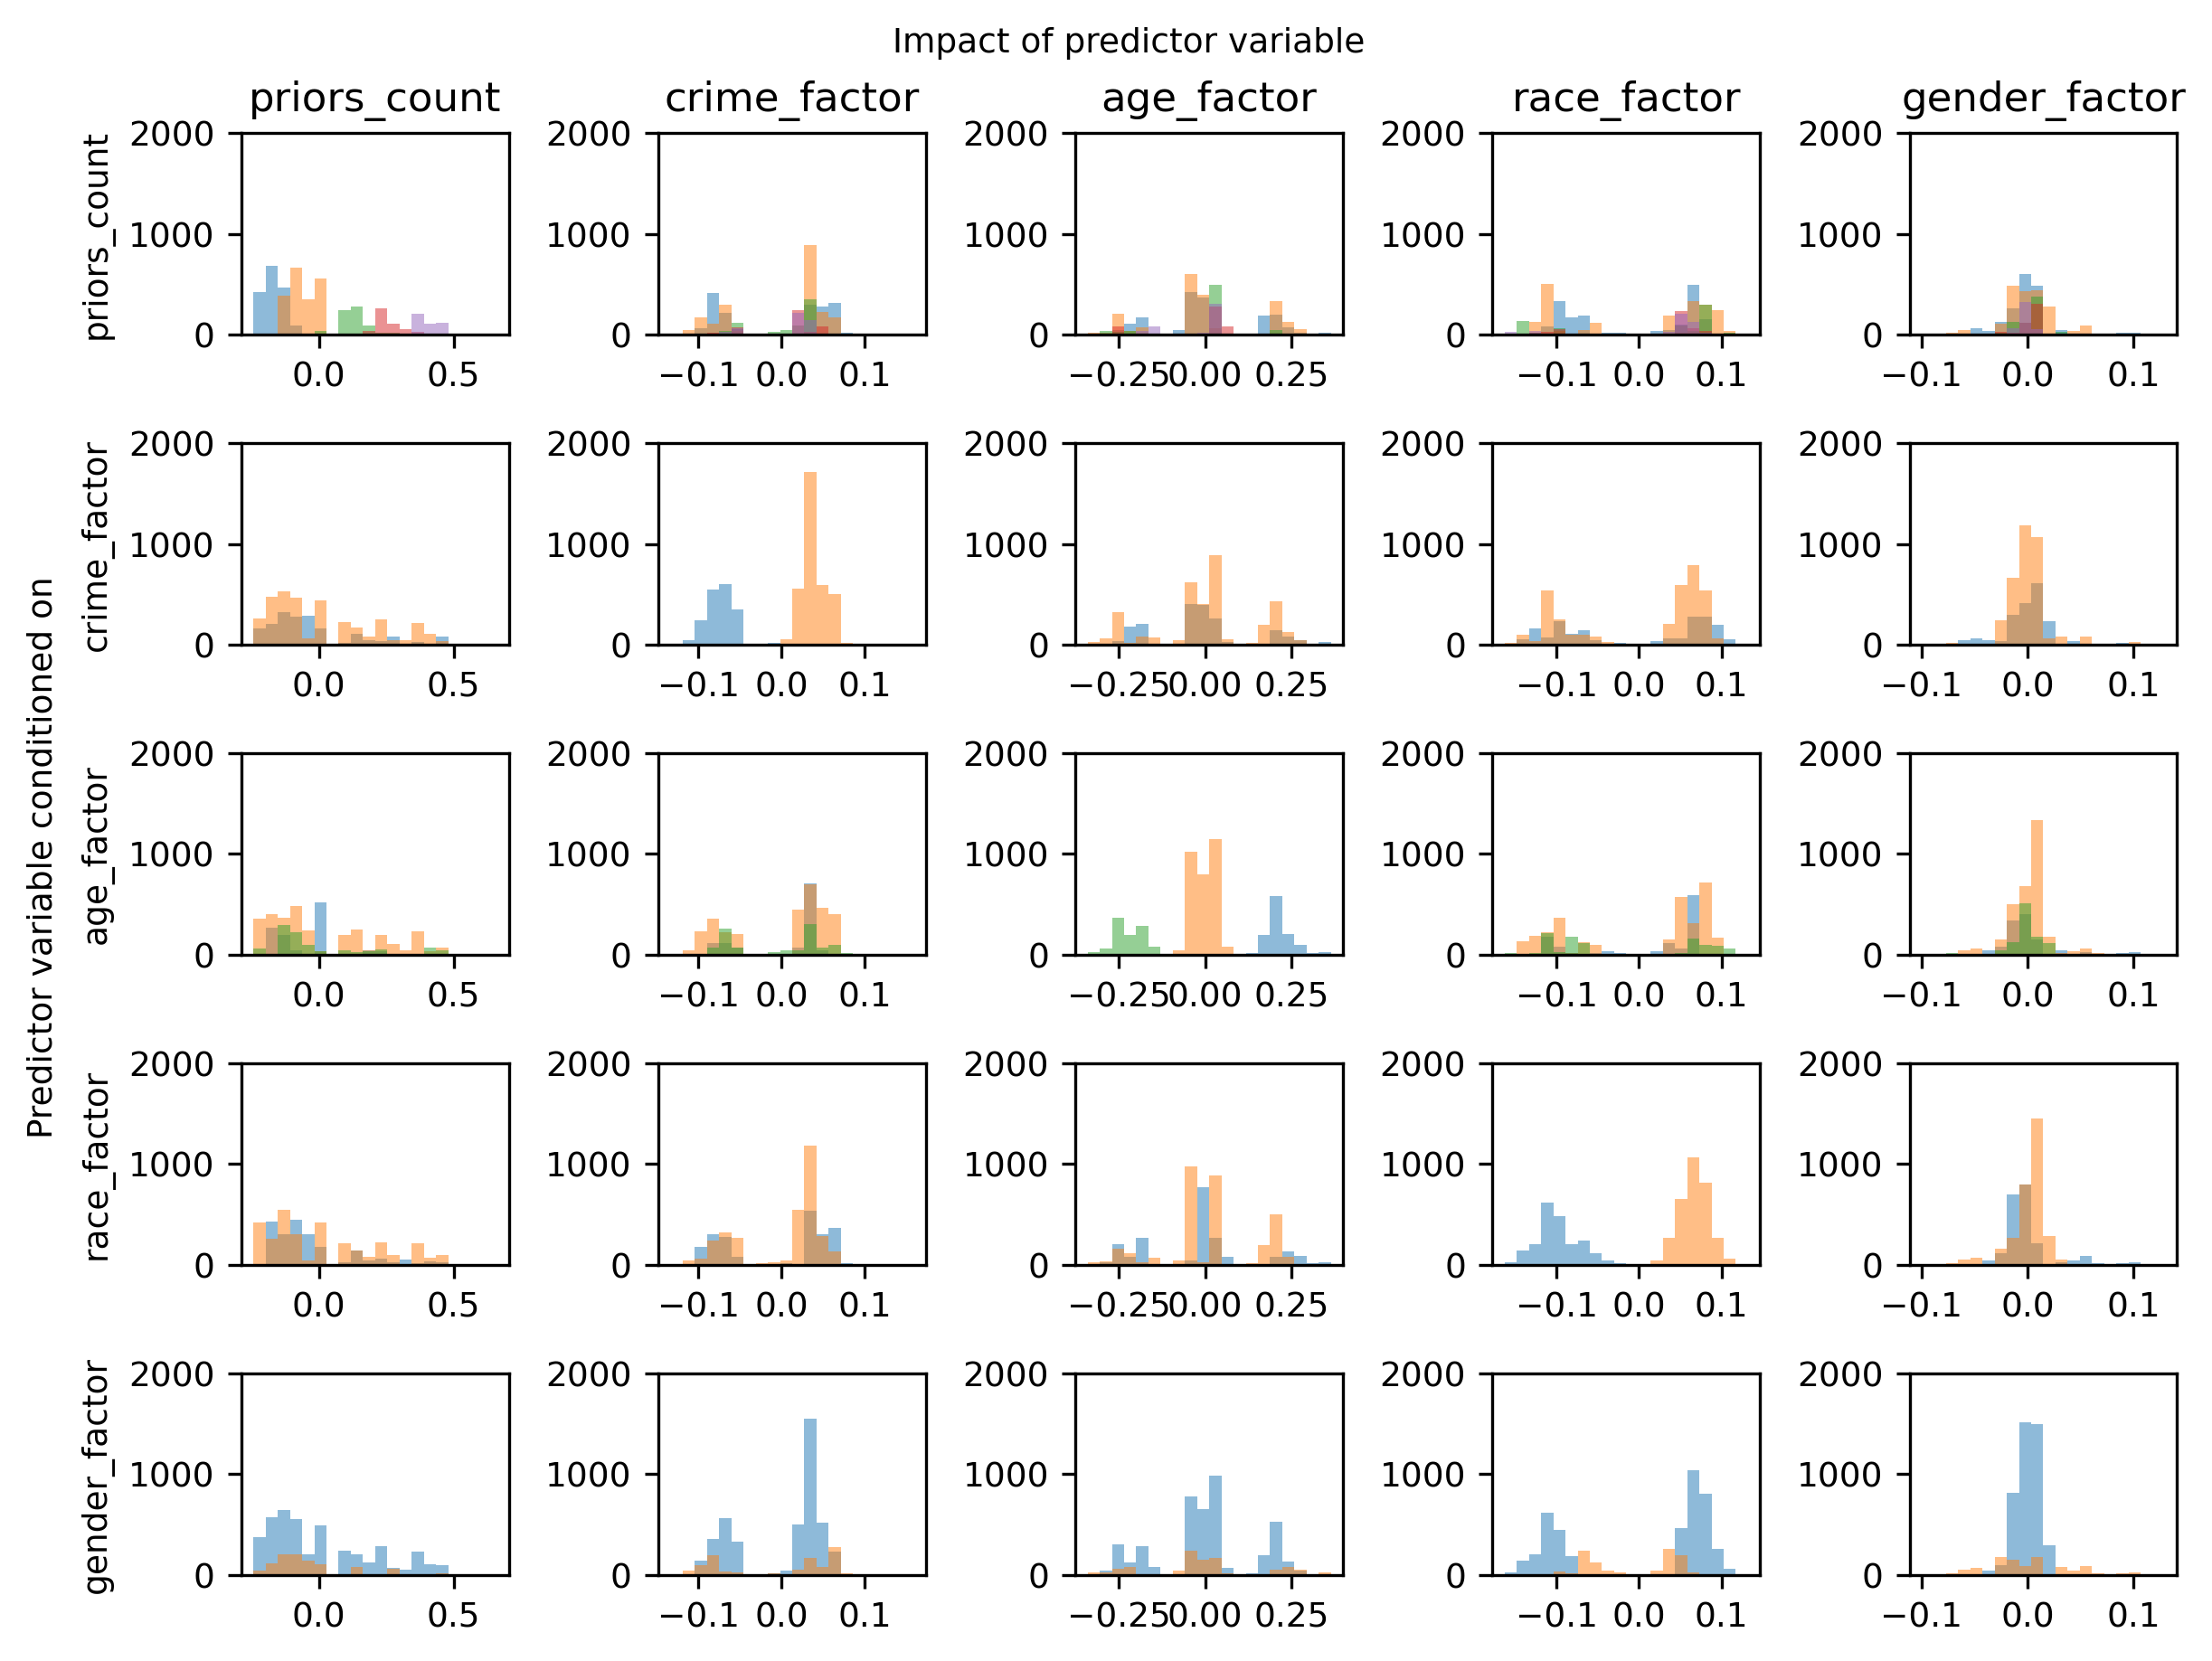

In [37]:
fig = plt.figure(figsize=(8,6),dpi=300)
plt.rcParams["font.size"] = 9
all_conditioned_shapley_hist(X_wr, bin_val, cs_fc.shapley_values)
plt.show()

### Response (Demographic Parity)

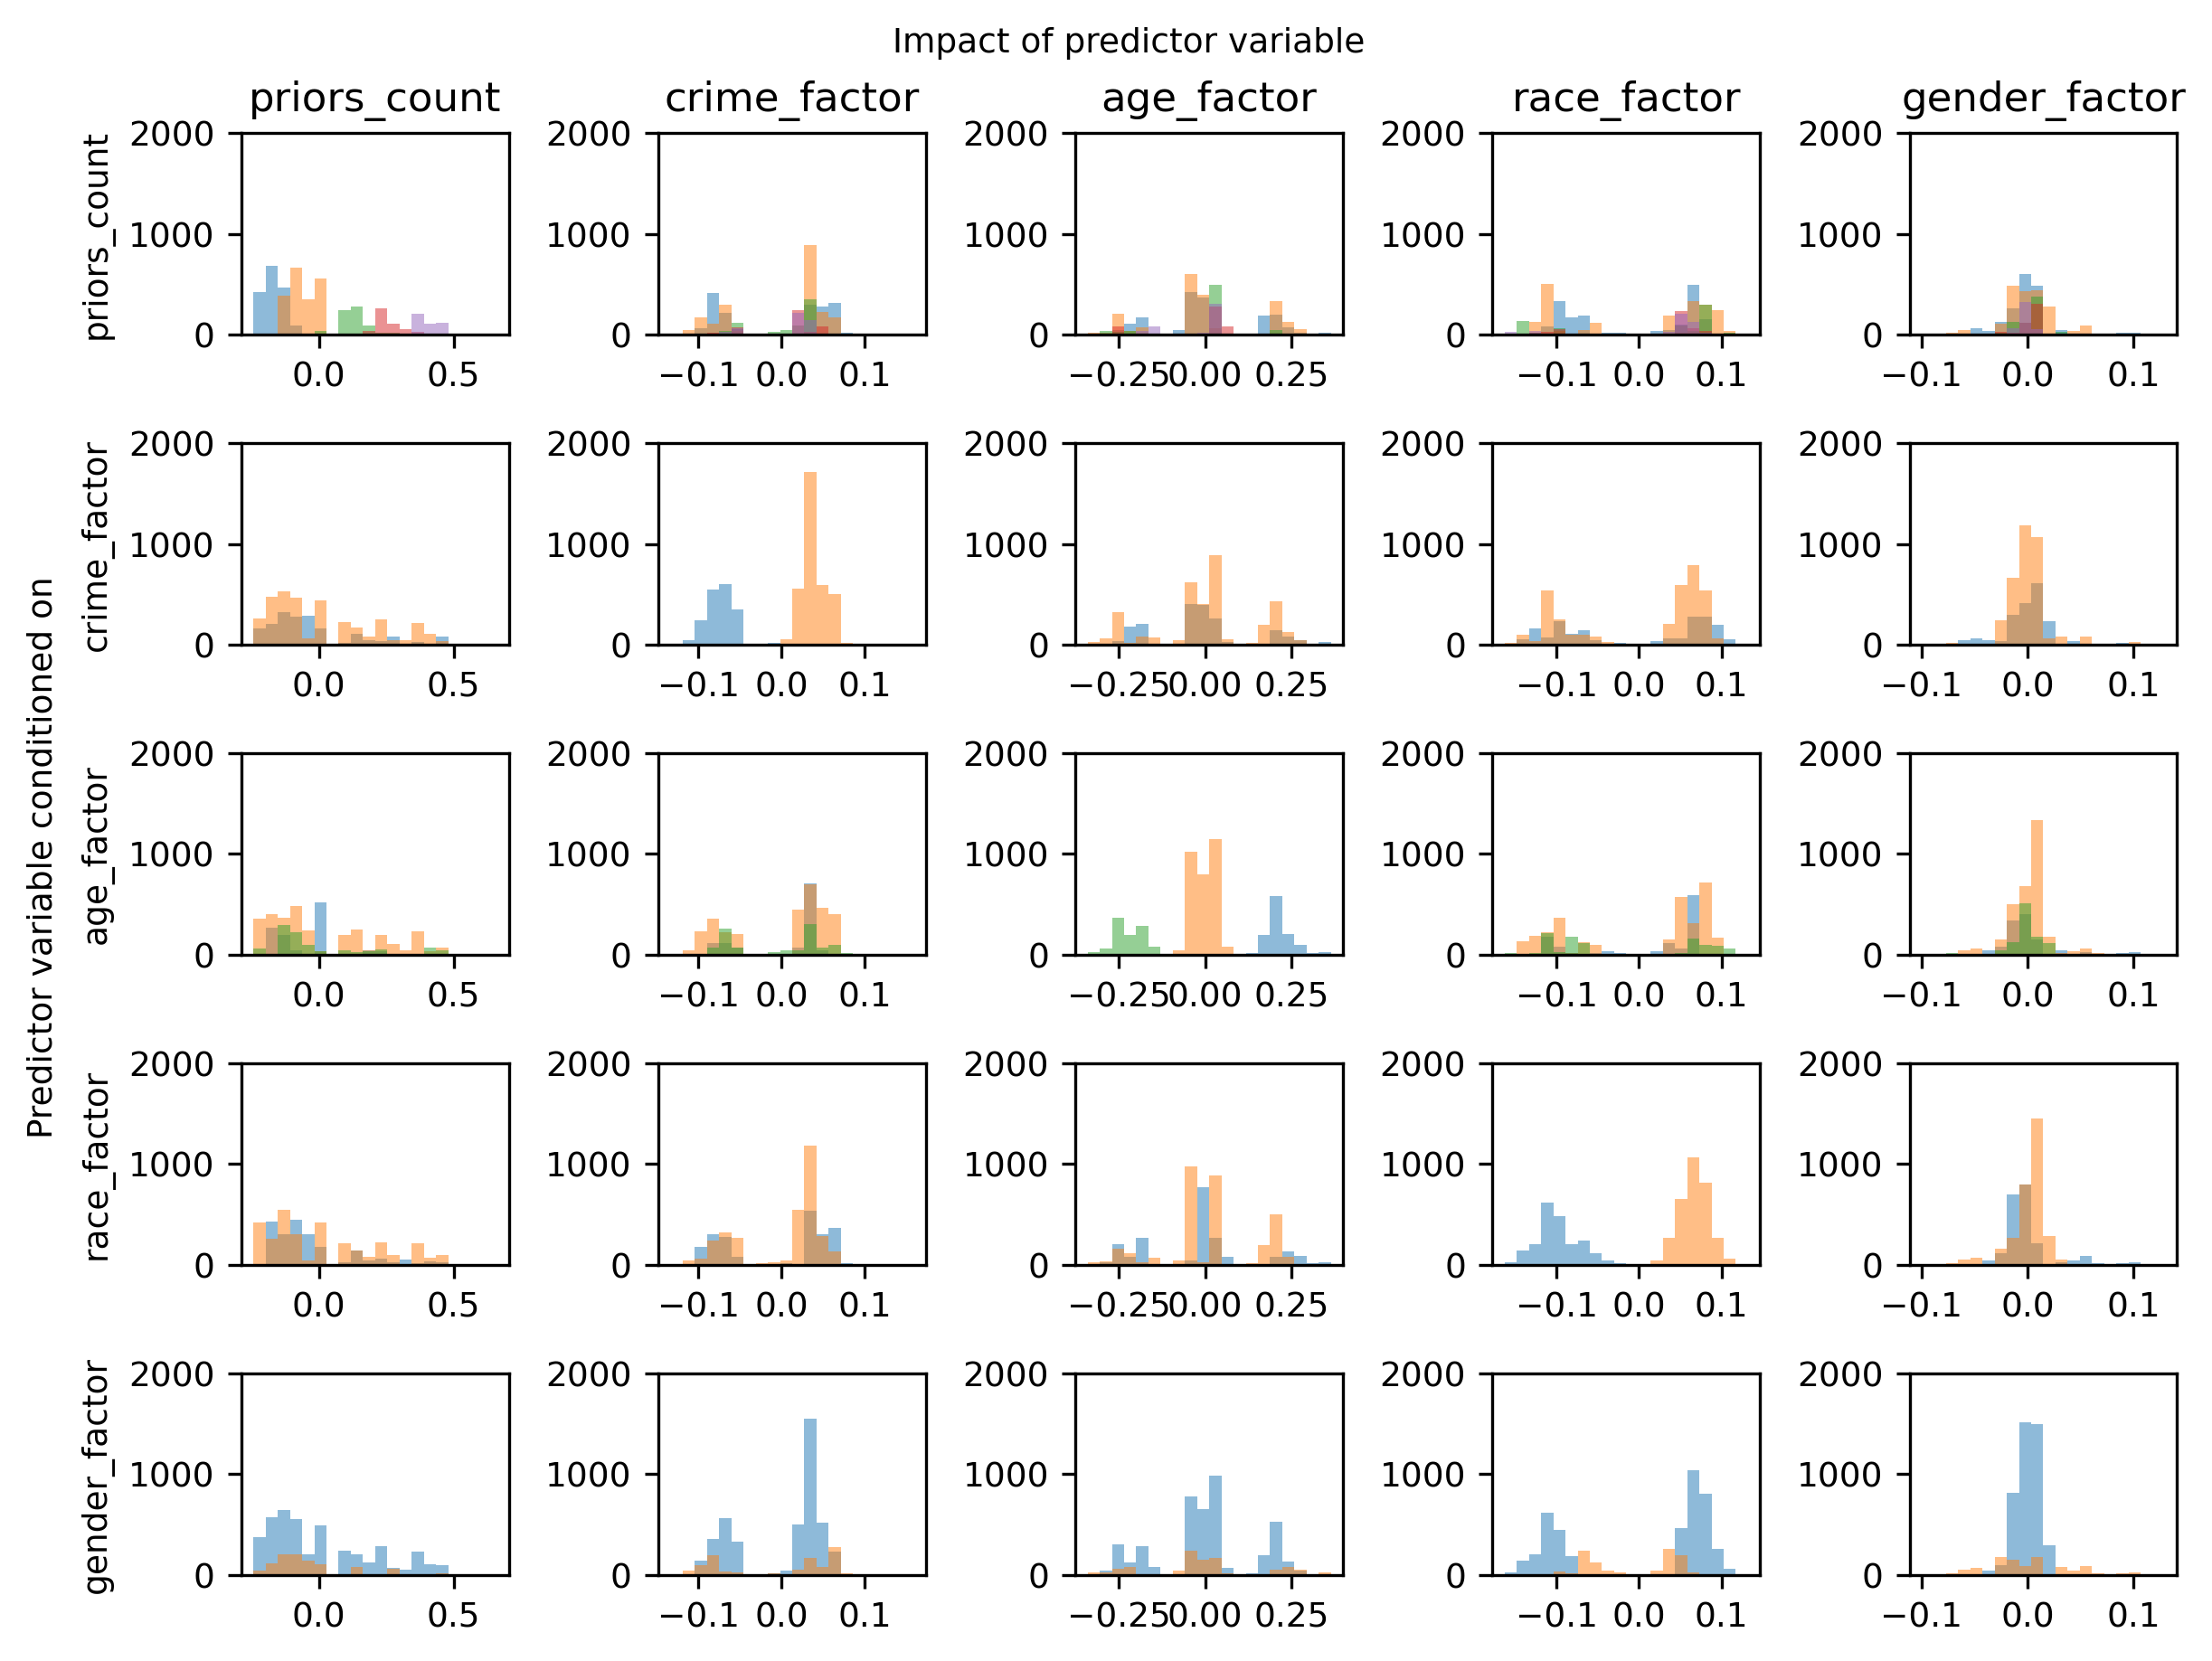

In [38]:
fig = plt.figure(figsize=(8,6),dpi=300)
plt.rcParams["font.size"] = 9
all_conditioned_shapley_hist(X_wr, bin_val, cs_fc.shapley_values)
plt.show()

### Residual

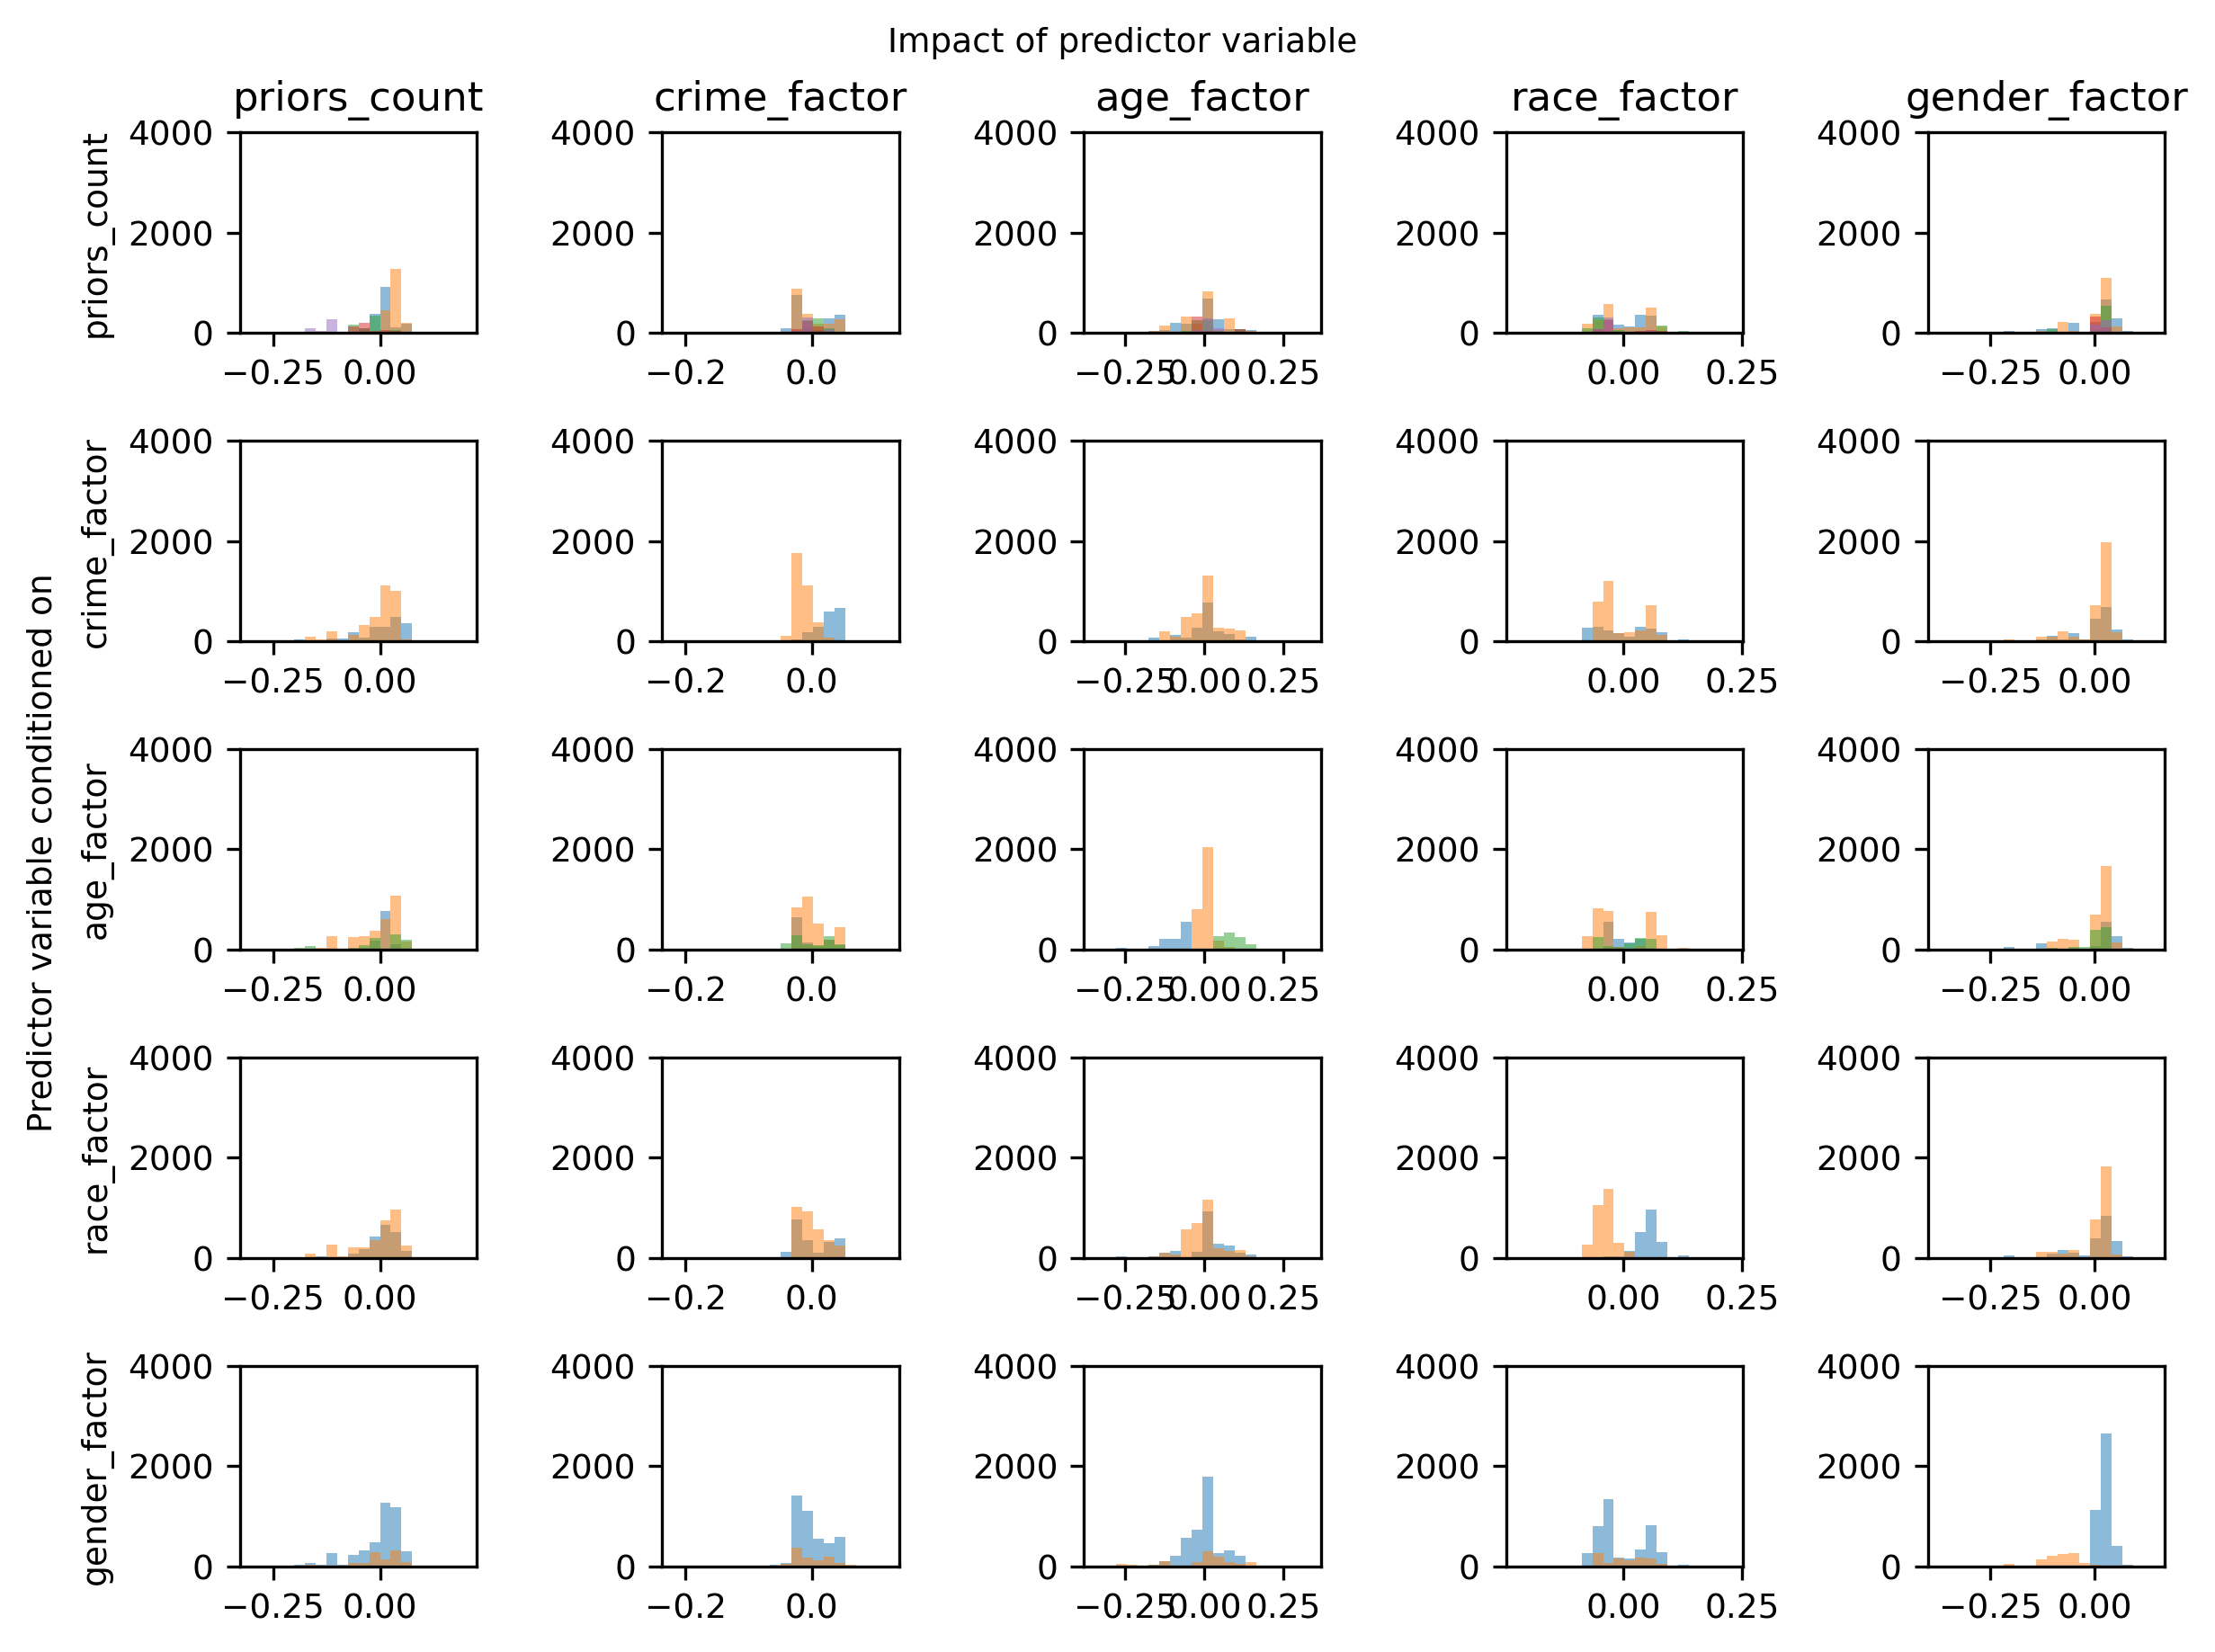

In [39]:
fig = plt.figure(figsize=(8,6),dpi=300)
plt.rcParams["font.size"] = 9
all_conditioned_shapley_hist(X_wr, bin_val, cs_res.shapley_values,ylim=(0,4000))
plt.show()

### FP (Equal opportunity)

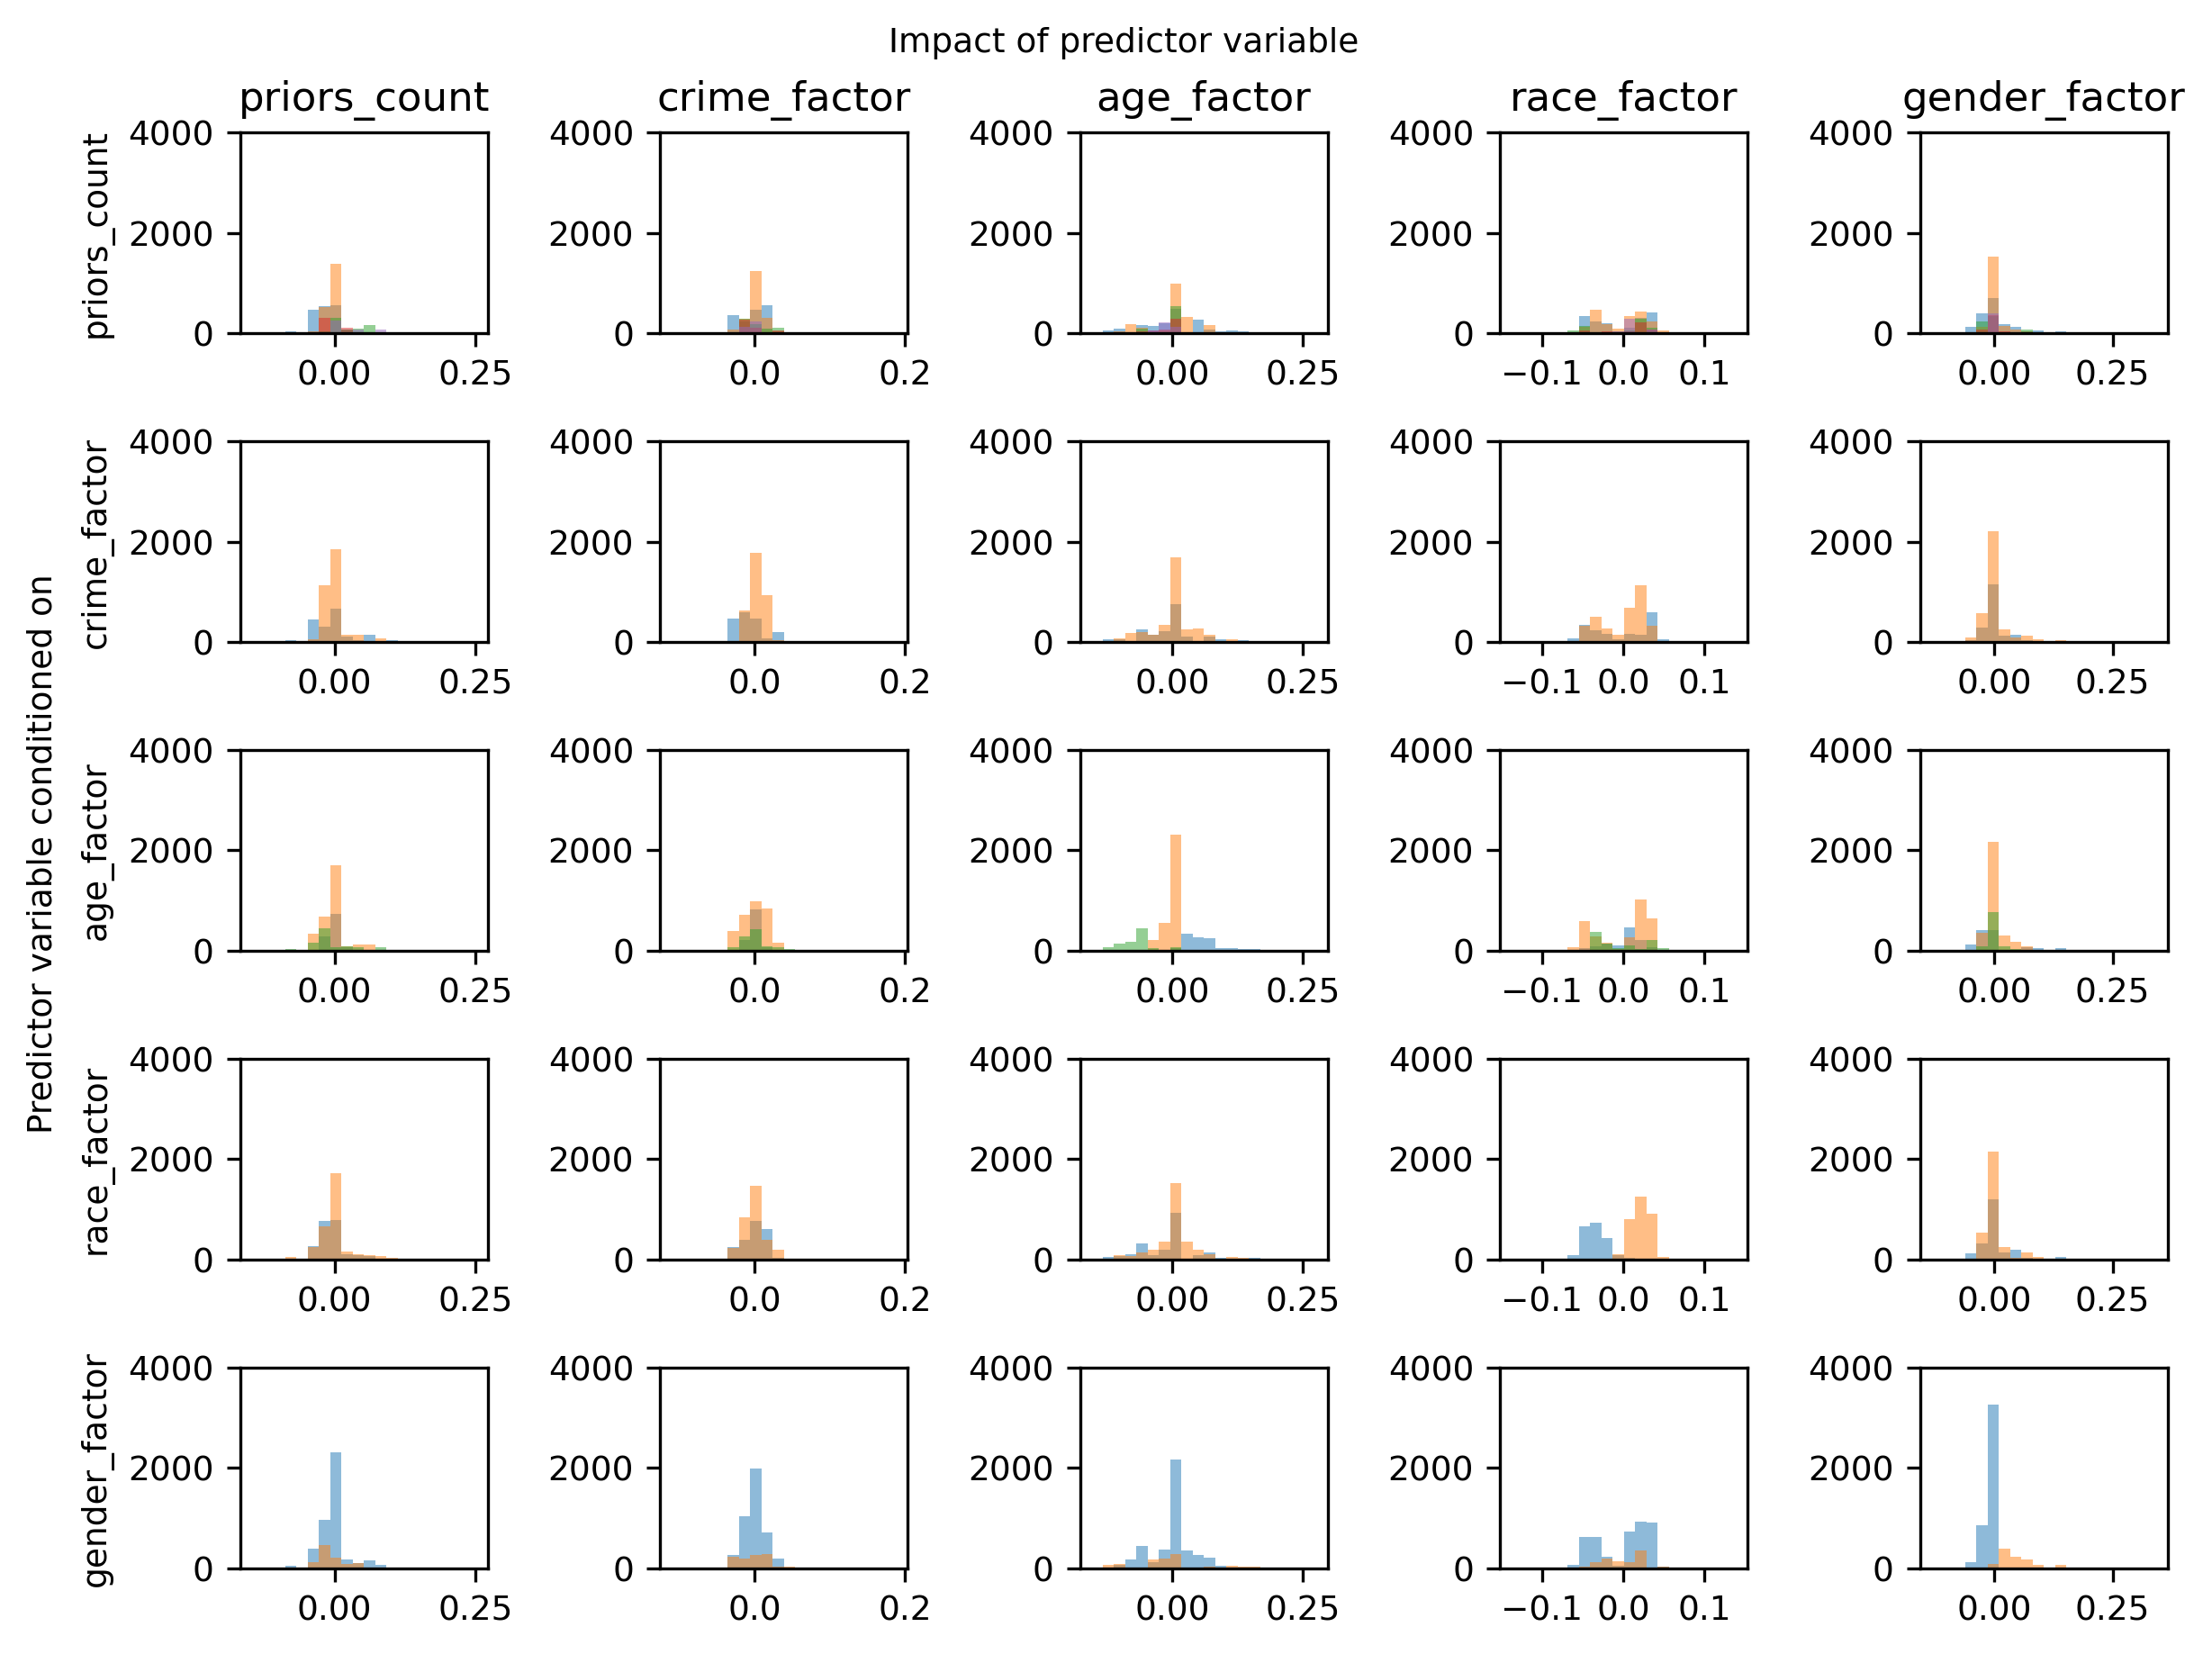

In [40]:
fig = plt.figure(figsize=(8,6),dpi=300)
plt.rcParams["font.size"] = 9
all_conditioned_shapley_hist(X_wr, bin_val, cs_fp.shapley_values,ylim=(0,4000))
plt.show()

### FN

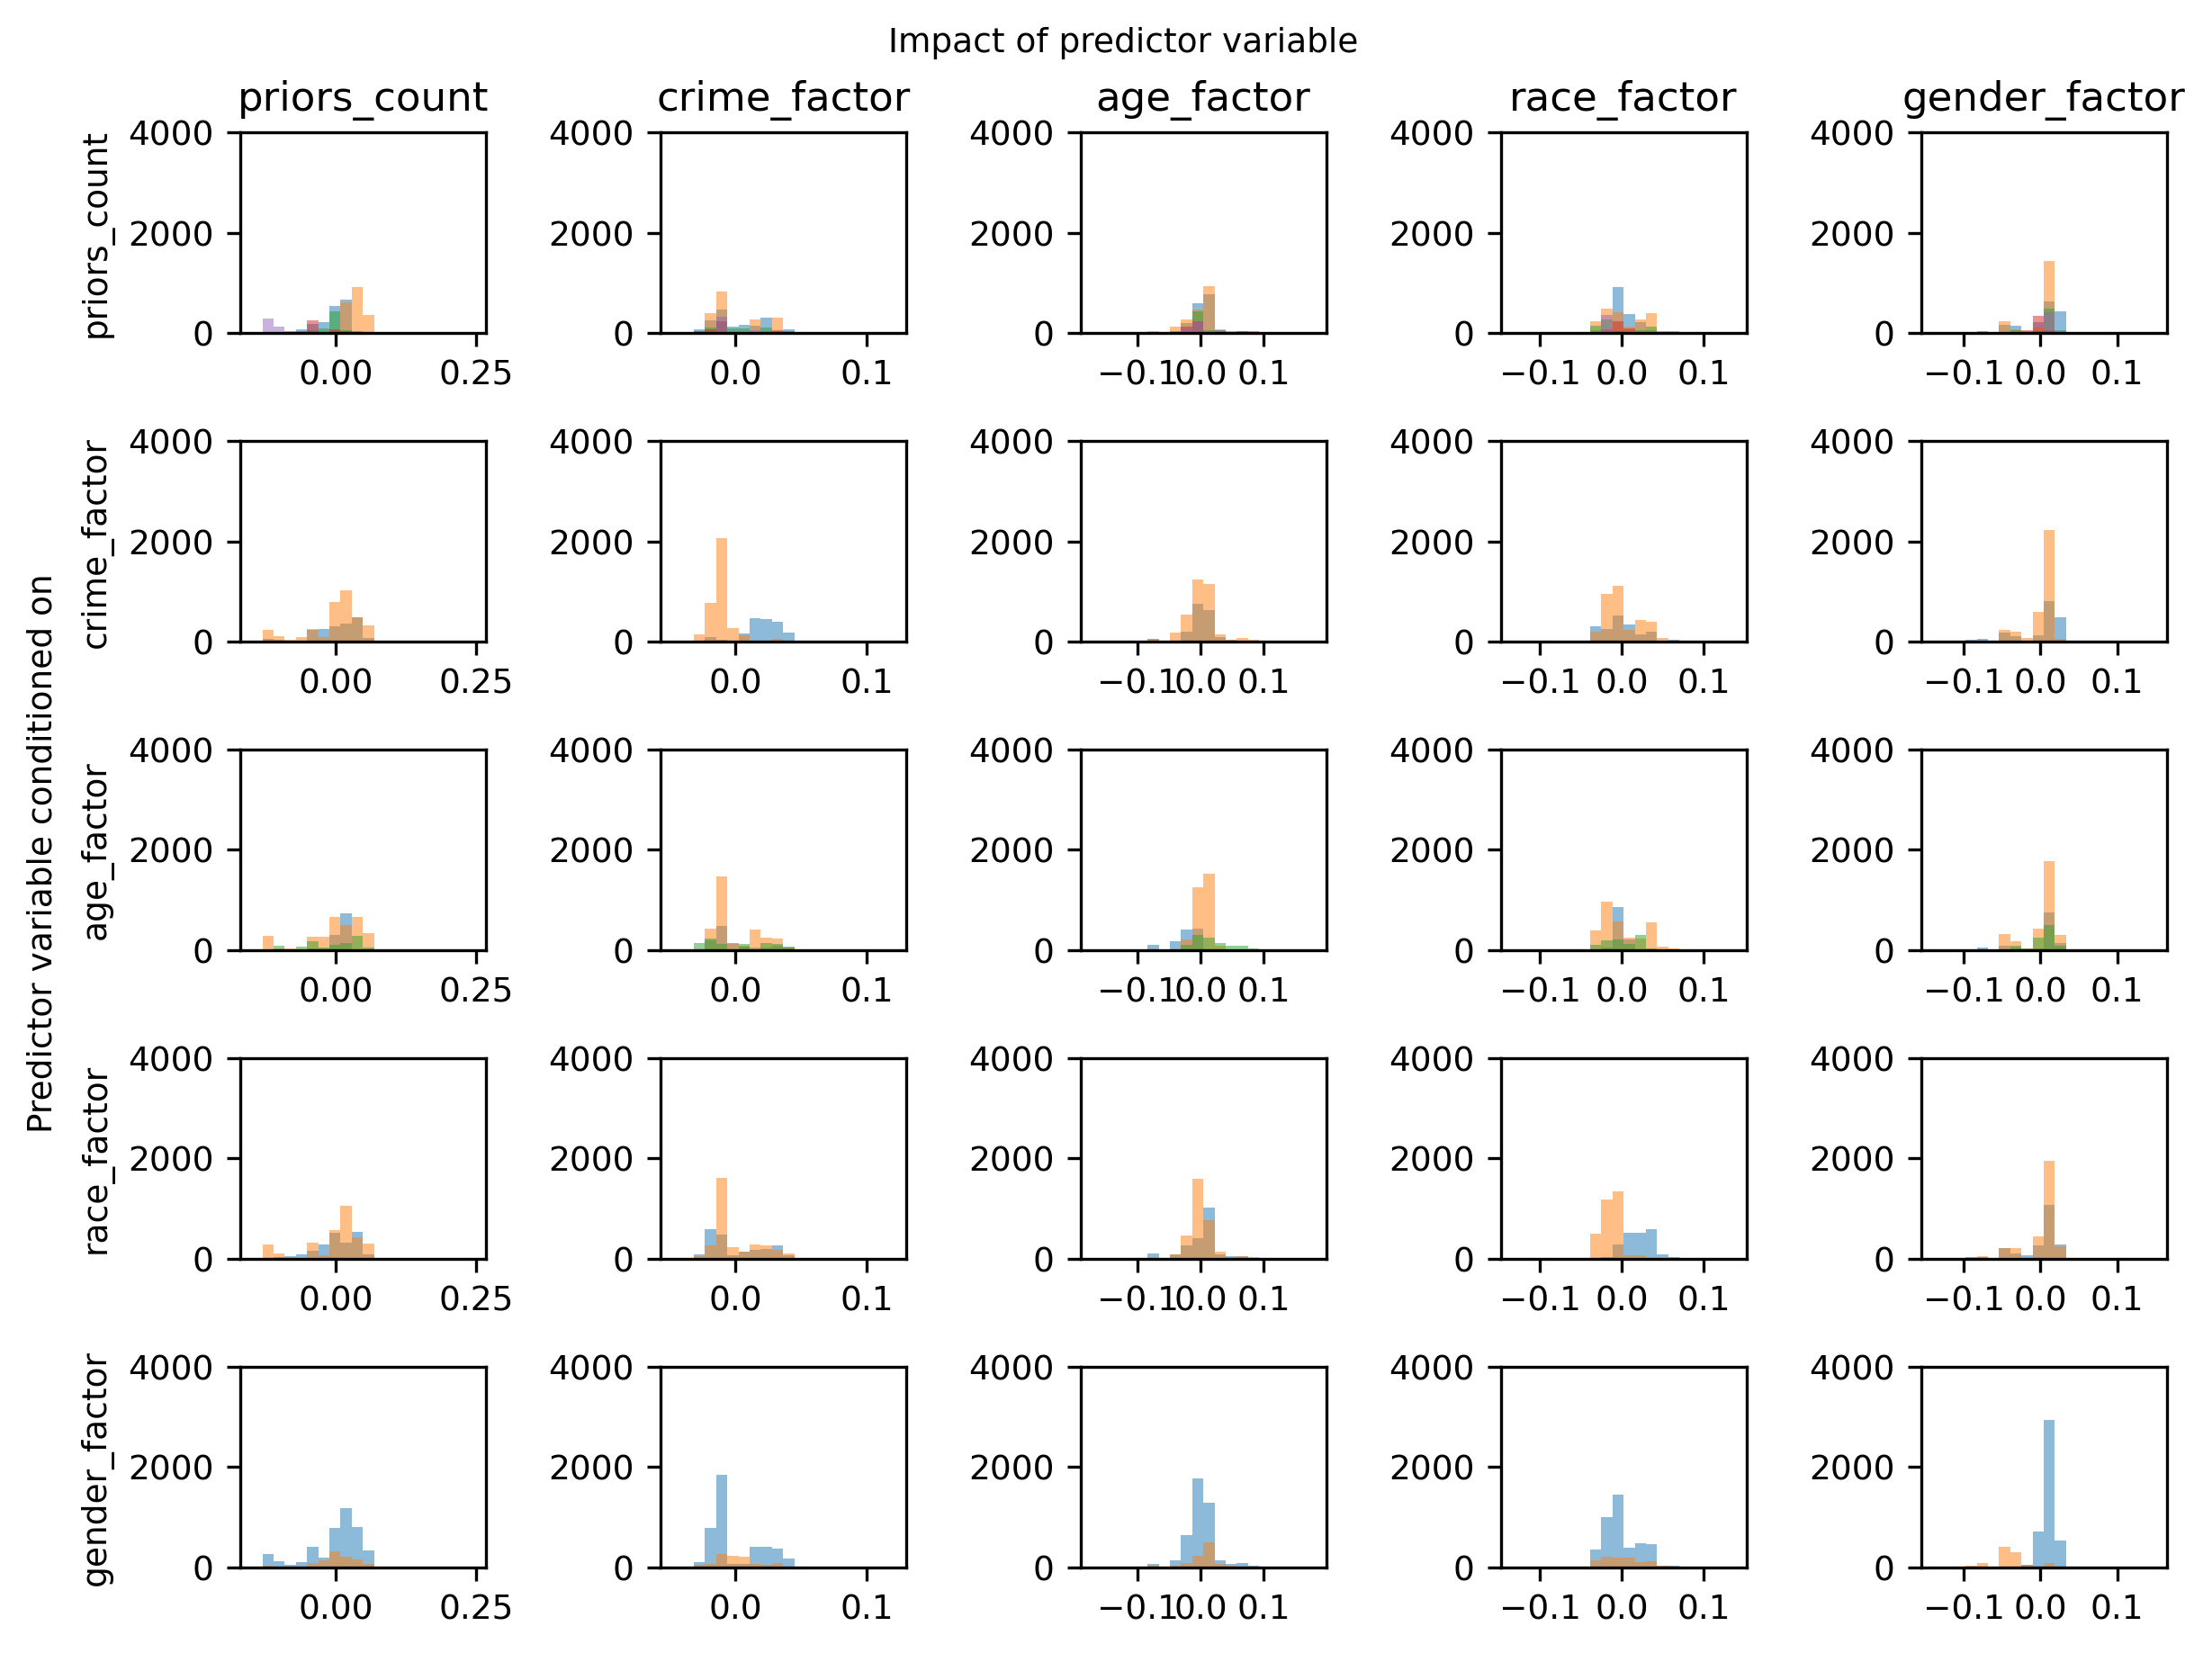

In [41]:
fig = plt.figure(figsize=(8,6),dpi=300)
plt.rcParams["font.size"] = 9
all_conditioned_shapley_hist(X_wr, bin_val, cs_fn.shapley_values,ylim=(0,4000))
plt.show()

## Table of mean cohort Shapley impact aggregated by group

In [42]:
def aggregate_impact_race_gender(cs_fc):
    temp = pd.DataFrame()
    temp['White'] = cs_fc.shapley_values[X['race_factor'] == 1].mean(axis=0)
    temp['Black'] = cs_fc.shapley_values[X['race_factor'] == 2].mean(axis=0)
    temp['Male'] = cs_fc.shapley_values[X['gender_factor'] == 1].mean(axis=0)
    temp['Female'] = cs_fc.shapley_values[X['gender_factor'] == 2].mean(axis=0)
    temp['White-Male'] = cs_fc.shapley_values[(X['race_factor'] == 1) & (X['gender_factor'] == 1)].mean(axis=0)
    temp['White-Female'] = cs_fc.shapley_values[(X['race_factor'] == 1) & (X['gender_factor'] == 2)].mean(axis=0)
    temp['Black-Male'] = cs_fc.shapley_values[(X['race_factor'] == 2) & (X['gender_factor'] == 1)].mean(axis=0)
    temp['Black-Female'] = cs_fc.shapley_values[(X['race_factor'] == 2) & (X['gender_factor'] == 2)].mean(axis=0)
    temp.index = X.columns
    return temp

In [43]:
pd.options.display.precision = 6

### prediction

In [44]:
agg_pred = aggregate_impact_race_gender(cs_fc)

In [45]:
agg_pred

,White,Black,Male,Female,White-Male,White-Female,Black-Male,Black-Female
priors_count,-0.025816,0.017099,0.006501,-0.026780,-0.023757,-0.032741,0.025179,-0.021547
crime_factor,-0.003690,0.002444,0.000955,-0.003933,-0.002017,-0.009315,0.002789,0.000791
age_factor,-0.017457,0.011563,0.000339,-0.001396,-0.016829,-0.019569,0.010936,0.014559
race_factor,-0.100013,0.066245,0.001479,-0.006092,-0.111034,-0.062947,0.070932,0.043824
gender_factor,-0.000470,0.000311,-0.000507,0.002090,-0.008910,0.027913,0.004679,-0.020582


### response

In [46]:
agg_truth = aggregate_impact_race_gender(cs_truth)

In [47]:
agg_truth

,White,Black,Male,Female,White-Male,White-Female,Black-Male,Black-Female
priors_count,-0.019426,0.012867,0.005289,-0.021786,-0.017130,-0.027148,0.019128,-0.017078
crime_factor,-0.002379,0.001576,0.000601,-0.002477,-0.001310,-0.005974,0.001781,0.000594
age_factor,-0.010224,0.006772,0.000236,-0.000973,-0.010527,-0.009204,0.006880,0.006253
race_factor,-0.045958,0.030441,0.000738,-0.003040,-0.053373,-0.021021,0.034140,0.012746
gender_factor,-0.001587,0.001051,0.019514,-0.080383,0.014117,-0.054399,0.022845,-0.103195


### residual

In [48]:
agg_res = aggregate_impact_race_gender(cs_res)

In [49]:
agg_res

,White,Black,Male,Female,White-Male,White-Female,Black-Male,Black-Female
priors_count,0.006390,-0.004232,-0.001212,0.004994,0.006627,0.005592,-0.006051,0.004468
crime_factor,0.001311,-0.000868,-0.000354,0.001457,0.000707,0.003341,-0.001009,-0.000197
age_factor,0.007233,-0.004791,-0.000103,0.000423,0.006302,0.010365,-0.004056,-0.008306
race_factor,0.054055,-0.035804,-0.000741,0.003052,0.057662,0.041926,-0.036792,-0.031077
gender_factor,-0.001117,0.000740,0.020021,-0.082473,0.023027,-0.082312,0.018166,-0.082613


### false positive

In [50]:
agg_fp = aggregate_impact_race_gender(cs_fp)

In [51]:
agg_fp

,White,Black,Male,Female,White-Male,White-Female,Black-Male,Black-Female
priors_count,-0.002498,0.001654,0.000508,-0.002094,-0.002129,-0.003736,0.002136,-0.000652
crime_factor,-0.000501,0.000332,0.000171,-0.000704,-0.000099,-0.001851,0.000337,0.000304
age_factor,-0.005711,0.003783,0.000027,-0.000112,-0.005006,-0.008084,0.003134,0.006887
race_factor,-0.032650,0.021626,0.000449,-0.001849,-0.035890,-0.021754,0.022880,0.015628
gender_factor,0.000577,-0.000382,-0.010739,0.044236,-0.013307,0.047271,-0.009153,0.041571


### false negative

In [52]:
agg_fn = aggregate_impact_race_gender(cs_fn)

In [53]:
agg_fn

,White,Black,Male,Female,White-Male,White-Female,Black-Male,Black-Female
priors_count,0.003892,-0.002578,-0.000704,0.002900,0.004497,0.001856,-0.003915,0.003817
crime_factor,0.000810,-0.000537,-0.000183,0.000753,0.000608,0.001489,-0.000671,0.000107
age_factor,0.001522,-0.001008,-0.000076,0.000311,0.001296,0.002282,-0.000922,-0.001419
race_factor,0.021405,-0.014178,-0.000292,0.001204,0.021771,0.020171,-0.013912,-0.015449
gender_factor,-0.000539,0.000357,0.009282,-0.038237,0.009720,-0.035042,0.009012,-0.041042


## Bayesian Bootstrap of group measures

In [65]:
subject = X_wr.values
wlb_cs_truth = np.load('bootstrap_cs_truth.npy')
wlb_cs_pred = np.load('bootstrap_cs_pred.npy')
wlb_cs_res = np.load('bootstrap_cs_res.npy')
wlb_cs_fp = np.load('bootstrap_cs_fp.npy')
wlb_cs_fn = np.load('bootstrap_cs_fn.npy')

In [66]:
def wlbcs_violinplot(values, cs_values, columns):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 1), dpi=300)
    plt.violinplot(values,showmeans=True, showmedians=True)
    plt.setp(axs, xticks=[y + 1 for y in range(len(columns))],
             xticklabels=columns.tolist())
    plt.plot(np.arange(len(columns))+1, cs_values, 'rx' )

In [67]:
idx_white = np.where(X['race_factor']==1)[0]
idx_black = np.where(X['race_factor']==2)[0]
idx_male = np.where(X['gender_factor']==1)[0]
idx_female = np.where(X['gender_factor']==2)[0]
idx_white_male = np.where((X['race_factor']==1) & (X['gender_factor']==1))[0]
idx_white_female = np.where((X['race_factor']==1) & (X['gender_factor']==2))[0]
idx_black_male = np.where((X['race_factor']==2) & (X['gender_factor']==1))[0]
idx_black_female = np.where((X['race_factor']==2) & (X['gender_factor']==2))[0]

In [68]:
race_impacts = np.zeros((1000,8))
race_impacts[:,0] = wlb_cs_res[:,idx_white,:].mean(axis=1)[:,3]
race_impacts[:,1] = wlb_cs_res[:,idx_black,:].mean(axis=1)[:,3]
race_impacts[:,2] = wlb_cs_res[:,idx_male,:].mean(axis=1)[:,3]
race_impacts[:,3] = wlb_cs_res[:,idx_female,:].mean(axis=1)[:,3]
race_impacts[:,4] = wlb_cs_res[:,idx_white_male,:].mean(axis=1)[:,3]
race_impacts[:,5] = wlb_cs_res[:,idx_white_female,:].mean(axis=1)[:,3]
race_impacts[:,6] = wlb_cs_res[:,idx_black_male,:].mean(axis=1)[:,3]
race_impacts[:,7] = wlb_cs_res[:,idx_black_female,:].mean(axis=1)[:,3]
race_impacts_cs = np.zeros((8))
race_impacts_cs[0] = cs_res.shapley_values[idx_white].mean(axis=0)[3]
race_impacts_cs[1] = cs_res.shapley_values[idx_black].mean(axis=0)[3]
race_impacts_cs[2] = cs_res.shapley_values[idx_male].mean(axis=0)[3]
race_impacts_cs[3] = cs_res.shapley_values[idx_female].mean(axis=0)[3]
race_impacts_cs[4] = cs_res.shapley_values[idx_white_male].mean(axis=0)[3]
race_impacts_cs[5] = cs_res.shapley_values[idx_white_female].mean(axis=0)[3]
race_impacts_cs[6] = cs_res.shapley_values[idx_black_male].mean(axis=0)[3]
race_impacts_cs[7] = cs_res.shapley_values[idx_black_female].mean(axis=0)[3]

In [69]:
impacts_columns = ['White','Black','Male','Female','WM','WF','BM','BF']

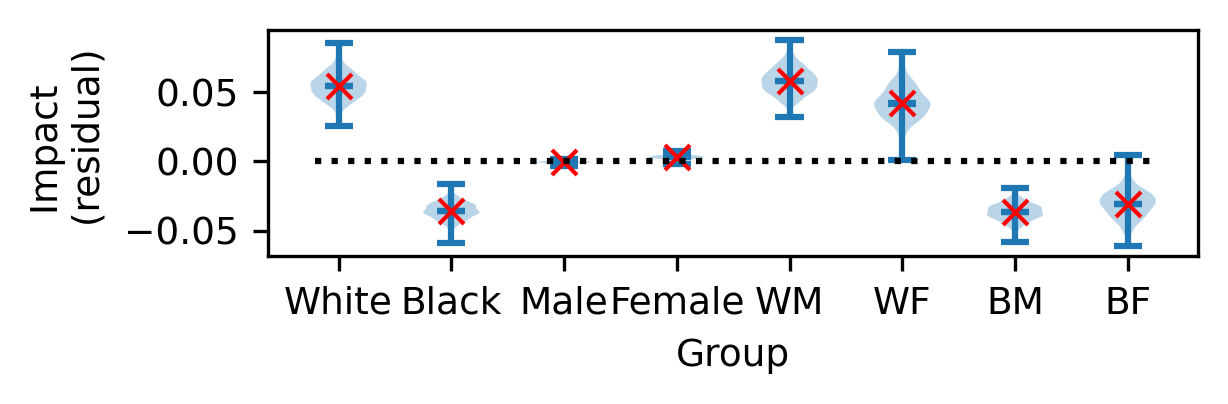

In [70]:
wlbcs_violinplot(race_impacts, race_impacts_cs, np.array(impacts_columns))
plt.ylabel("Impact \n (residual)")
plt.xlabel('Group')
plt.axhline(y=0, xmin= 0.05, xmax=0.95, color='black',linestyle = ':')

## FPR / FNR revisited (Subsetting to N / P)

In [71]:
Y_N = Y[Y['two_year_recid'] == 0]
X_N = X_wr[Y['two_year_recid'] == 0]
subject = X_N.values
similarity.ratio = 0.1
cs.dump=False
f=False
cs_fpr = cs.CohortShapley(f, similarity.similar_in_samebin, np.arange(len(subject)), subject, y=Y_N['FP'].values, parallel=4)

use given y values instead of model prediction.


In [72]:
cs_fpr.compute_cohort_shapley()

parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.


100%|██████████| 699/699 [00:11<00:00, 59.10it/s]


In [73]:
Y_P = Y[Y['two_year_recid'] == 1]
X_P = X_wr[Y['two_year_recid'] == 1]
subject = X_P.values
similarity.ratio = 0.1
cs.dump=False
f=False
cs_fnr = cs.CohortShapley(f, similarity.similar_in_samebin, np.arange(len(subject)), subject, y=Y_P['FN'].values, parallel=4)

use given y values instead of model prediction.


In [74]:
cs_fnr.compute_cohort_shapley()

parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.


  0%|          | 0/621 [00:00<?, ?it/s]

use given y values instead of model prediction.


100%|██████████| 621/621 [00:08<00:00, 72.62it/s]


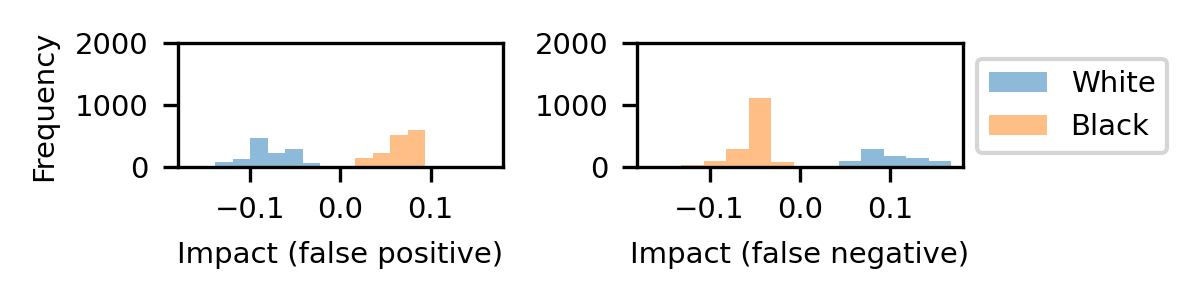

In [75]:
fig = plt.figure(figsize=(4,1),dpi=300)
plt.rcParams["font.size"] = 7

plt.subplot(1,2,1)
conditioned_shapley_hist(X_N, bin_val, cs_fpr.shapley_values,3,3, bin_label=['White','Black'],xlim=xlim)
#plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (false positive)')
plt.ylabel('Frequency')
#
plt.subplot(1,2,2)
conditioned_shapley_hist(X_P, bin_val, cs_fnr.shapley_values,3,3, bin_label=['White','Black'],xlim=xlim)
plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.xlabel('Impact (false negative)')

plt.tight_layout()
plt.show()